# Running Equation of State with Quantum Espresso Workgraph

## Aim

This notebook demonstrates how we can connect and execute tasks in a workflow. In this example; we get an initial structure, generate structures like we would do to fit an equation of state. Then as we want to use the structures for fine tuning we run DFT calculations like `Quantum Espresso` to get the reference energies and forces. Then split structures into `test`, `train` and `valid` files. This workgraph asuumed an initail structure and has a task which creates atoms in fractional coordinates, this time we do not run geometry optimisation or descriptors calculation tasks.

### Setup

For this tutorial we will assume you have: 
<ul>
        <li>An AiiDA profile setup</li>
        <li>An external computer setup in AiiDA with quantum espresso configured</li>
                <ul>
                        <li>A tutorial can be found in <a href="../aiida_setup/setup-external-computer.ipynb"><code>../aiida_setup/setup-external-computer.ipynb</code></a></li>
                </ul>
        <li>The <code>aiida-quantumespresso</code>, <code>aiida-pseudo</code> and <code>fpsample</code> extra dependencies installed</li>
        <li>Pseudopotentials SSSP installed</li>
                <ul>
                        <li>They can be installed with: <code>aiida-pseudo install sssp</code></li>
                </ul>

</ul>

The initial setup is very similar to the other tutorials, such as <a href="../calculations/singlepoint.ipynb"><code>../calculations/singlepoint.ipynb</code></a>, which goes into more detail about what each step is doing

Load the aiida profile, model and code:

In [1]:
from aiida import load_profile  
load_profile()

Profile<uuid='c677ac2b24bc40178ad9f1681fc23d0a' name='presto'>

In [2]:
from aiida.orm import load_code
from aiida_mlip.data.model import ModelData
from ase.build import bulk

uri = "https://github.com/stfc/janus-core/raw/main/tests/models/mace_mp_small.model"
model = ModelData.from_uri(uri, architecture="mace_mp")

janus_code = load_code("janus@localhost")
qe_code = load_code("qe@localhost")

initial_atoms = bulk("NaCl", "rocksalt", 5.63)

First, we set up the scaling task. It takes a `StructureData` object as input and produces atoms in fractional coordinates. The number of generated atomic structures is determined by the `num_structs` parameter. The task returns a dictionary containing these structures.

In [3]:
from aiida_workgraph import WorkGraph, task
import numpy as np
from aiida.orm import Int, Float, List, Dict, SinglefileData,InstalledCode, KpointsData, StructureData, load_group

from random import shuffle

@task.calcfunction(outputs=["scaled_structures"])
def create_scales(
    min_v: Float,
    max_v: Float,
    num_structs: Int,
    structure: StructureData
): 
    lattice_scalars = np.cbrt(np.linspace(min_v.value, max_v.value, num_structs.value))
    scaled_structures = {}

    atom = structure.get_ase()
    cell = atom.get_cell()

    for i, scalars in enumerate(lattice_scalars):
        scaled_atom = atom.copy()
        scaled_atom.set_cell(cell * scalars, scale_atoms=True)
        struct_data = f"struct{i}"
        scaled_structures[struct_data] = StructureData(ase=scaled_atom)


    return {
        "scaled_structures": scaled_structures
    }

Before setting up the work graph, we first configure the `Quantum Espresso (QE)` task by defining the code and input parameters. Since we need to run QE on multiple structures, we create multiple `PwCalculation` tasks dynamically within the same task using `get_current_graph()`. This allows us to run QE for each structure and return the corresponding `TrajectoryData` and parameters for each.

In [4]:
from aiida_quantumespresso.calculations.pw import PwCalculation
from aiida_workgraph.manager import get_current_graph

@task.graph(outputs=["structures"])
def qe(
    code: InstalledCode,
    kpoints_mesh: List,
    task_metadata: Dict,
    **scaled_structures,
):

    wg = get_current_graph()

    kpoints = KpointsData()
    kpoints.set_kpoints_mesh(kpoints_mesh)

    pseudo_family = load_group('SSSP/1.3/PBE/efficiency')
    
    output_structures = {}

    for i, structs in scaled_structures.items():
        
        structure = StructureData(ase=structs.get_ase())
        pseudos = pseudo_family.get_pseudos(structure=structure)

        ecutwfc, ecutrho = pseudo_family.get_recommended_cutoffs(
            structure=structure,
            unit='Ry',
        )

        pw_params = {
            "CONTROL": {
                "calculation": "scf",
                'tprnfor': True,
                'tstress': True,
            },
            "SYSTEM": {
                "ecutwfc": ecutwfc,
                "ecutrho": ecutrho,
            },
        }
        
        qe_task = wg.add_task(
            PwCalculation,
            code=code,
            parameters=pw_params,
            kpoints=kpoints,
            pseudos=pseudos,
            metadata=task_metadata.value,
            structure=structure,
        )

        output_structures[f"struct{i}"] = {
                "trajectory":qe_task.outputs.output_trajectory,
                "parameters": qe_task.outputs.output_parameters
            }
        
        wg.update_ctx({
            "structures": output_structures
        })

    return {
        "structures": wg.ctx.structures,
    }

The `create_train_files` task extracts the attributes needed from each structure and splits structures into random test, train and validation files. This task returns `SinglefileData` instances of `test_file`, `train_file` and `valid_file`. This task differes from `descriptors_filter_qe.ipynb` `create_train_file` as in this task we split up the training files within the task as oppose to having them passed in and this task returns `SinglefileData` objects of the structures split up into `test_file`, `train_file` and `valid_file`.

In [ ]:
from pathlib import Path
from ase.io import iread, write
from ase import units
from tempfile import NamedTemporaryFile

@task.calcfunction(outputs=["test_file", "train_file", "valid_file"])
def create_train_files(**structures):
    
    structures_stack = list(structures.keys())
    shuffle(structures_stack)
    
    n = len(structures_stack)
    i1 = int(n*0.7)
    i2 = int(n*0.9)

    training_split = {
        "test": structures_stack[:i1],
        "train": structures_stack[i1:i2],
        "valid": structures_stack[i2:]
    }

    files = {}

    for split, split_structures in training_split.items():
        
        with NamedTemporaryFile(suffix=f"{split}.extxyz") as tmp:

            for struct in split_structures:

                trajectory = structures[struct]["trajectory"]
                fileStructure = trajectory.get_structure(index=0)
                fileAtoms = fileStructure.get_ase()

                stress = trajectory.arrays["stress"][0]
                converted_stress = stress * units.GPa
                fileAtoms.info["qe_stress"] = converted_stress

                fileAtoms.info["units"] = {"energy": "eV","forces": "ev/Ang","stress": "ev/Ang^3"}
                fileAtoms.set_array("qe_forces", trajectory.arrays["forces"][0])

                parameters = structures[struct]["parameters"]
                fileParams = parameters.get_dict()
                fileAtoms.info["qe_energy"] = fileParams["energy"]
                
                write(Path(tmp.name), fileAtoms, append=True)

            files[f"{split}_file"] = SinglefileData(tmp)

    
    for filename, file in files.items():
        with file.as_path() as path:
            num_structs = sum(1 for _ in iread(path))
        print(f"{filename} has {num_structs} structures")

    return{
        "test_file": files["test_file"],
        "train_file": files["train_file"],
        "valid_file": files["valid_file"]
    }


Setup the QE inputs these variables can be changed to your configuration.

In [6]:
qe_inputs = {
    "task_metadata": Dict({
            "options": {
                "resources": {
                    "num_machines": 1,
                },
                "max_wallclock_seconds": 3600,
                "queue_name": "scarf",
                "qos": "scarf",
                "environment_variables": {},
                "withmpi": True,
                "prepend_text": """
                """,
                "append_text": "",
            },
    }),
    "kpoints_mesh": List([1, 1, 1]),
    "code": qe_code,
}

In [7]:
from ase.build import bulk

with WorkGraph("EOS_workflow") as wg:

    initial_structure = StructureData(ase=initial_atoms)

    scales_task = wg.add_task(
        create_scales,
        min_v=0.95,
        max_v=1.05,
        num_structs=15,
        structure=initial_structure
    )

    qe_task = wg.add_task(
        qe,
        **qe_inputs,
        scaled_structures=scales_task.outputs.scaled_structures
    )
    
    train_task = wg.add_task(
        create_train_files,
        structures=qe_task.outputs.structures
    )
 

Visualise and run `WorkGraph`:

In [8]:
wg

In [9]:
wg.run()

11/28/2025 11:50:54 AM <28924> aiida.broker.rabbitmq: [WARNING] RabbitMQ v3.12.1 is not supported and will cause unexpected problems!
11/28/2025 11:50:54 AM <28924> aiida.broker.rabbitmq: [WARNING] It can cause long-running workflows to crash and jobs to be submitted multiple times.
11/28/2025 11:50:54 AM <28924> aiida.broker.rabbitmq: [WARNING] See https://github.com/aiidateam/aiida-core/wiki/RabbitMQ-version-to-use for details.
11/28/2025 11:50:54 AM <28924> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [5484|WorkGraphEngine|continue_workgraph]: tasks ready to run: create_scales
11/28/2025 11:50:55 AM <28924> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [5484|WorkGraphEngine|update_task_state]: Task: create_scales, type: CALCFUNCTION, finished.
11/28/2025 11:50:55 AM <28924> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [5484|WorkGraphEngine|continue_workgraph]: tasks ready to run: qe
11/28/2025 11:50:56 AM <28924> aiida

test_file has 10 structures
train_file has 3 structures
valid_file has 2 structures


{}

We can can use the outputs to viusualise the data, in this example we will print a simple bar chart of the energies:

In [10]:
output_files = {
    "test_file": wg.tasks.create_train_files.outputs.test_file.value,
    "train_file": wg.tasks.create_train_files.outputs.train_file.value,
    "valid_file": wg.tasks.create_train_files.outputs.valid_file.value
}


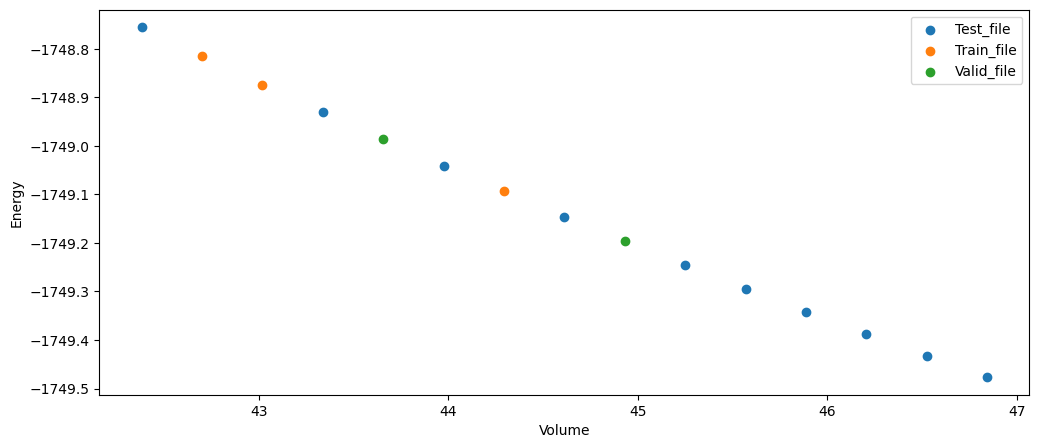

In [11]:
from ase.io import iread
import matplotlib.pyplot as plt

energies = {}
volumes = {}
for key, file in output_files.items():
    with file.as_path() as path:
        energies[key]= np.array([struct.info['qe_energy']
                        for struct in iread(path, index=':')])
        volumes[key]= np.array([struct.get_volume() 
                        for struct in iread(path, index=':')])
        
lens = np.cumsum([len(x) for x in energies.values()])

fig, ax = plt.subplots(figsize=(12, 5))
for (key, energy), volume in zip(energies.items(), volumes.values(), strict=True):
    ax.scatter(volume, energy, label=key.capitalize())

ax.set_ylabel("Energy")
ax.set_xlabel("Volume")
ax.legend()

plt.show()


In [ ]:
from workgraph_collections.cp2k.eos import eos_workgraph